# Post Processing

This notebook run some post processing on result point cloud. 
1. Convert point cloud to DEM with `point2dem` command from ASP.
2. Coregister with reference DEMs.
3. Compute difference between coregistered DEMs and references DEMs.
4. Compute some statistics of this difference.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import history
from glob import glob

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# For testing only

Temporay commands for testing:
- create a symlink to the files needed/working for this notebook
- create downsampled version of the reference DEMs

In [3]:
# !ln -fs /mnt/summer/USERS/DEHECQA/history/output/extracted/**/*dense_pointcloud.laz /mnt/summer/USERS/DEHECQA/history/output/test_data/pointclouds
# !rm /mnt/summer/USERS/DEHECQA/history/output/test_data/HIATUS*laz # wrong code
#!ls -1 /mnt/summer/USERS/DEHECQA/history/output/test_data/pointclouds/*laz

In [ ]:
#!gdal_translate /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom.tif /home/godinlu/github/history/dev/testset/ref_dems/casa_grande_reference_dem_zoom_30m.tif -tr 30 30 -r nearest
#!gdal_translate /mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom_mask.tif /home/godinlu/github/history/dev/testset/ref_dems/casa_grande_reference_dem_zoom_mask_30m.tif -tr 30 30 -r nearest

Input file size is 51255, 24360
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 51255, 24360
0...10...20...30...40...50...60...70...80...90...100 - done.


# Settings

In [29]:
# contain the .las or .laz files
pointcloud_files = history.postprocessing.find_pointclouds("/mnt/summer/USERS/DEHECQA/history/output/extracted")

POSTPROC_CSV_FILE = "/mnt/summer/USERS/DEHECQA/history/output/test_data/postprocess.csv"

# Directory where put DEMs after point2dem command
RAW_DEM_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/dems"

# Directory of coregistered DEMs
COREGISTERED_DEM_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems"

# Directory of diference beetween ref DEMs and coregistered DEMs
DDEMS_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/ddems"
DDEM_PLOTS_DIRECTORY = "/mnt/summer/USERS/DEHECQA/history/output/test_data/ddem_plots"

# dictionnary of all references DEMs
REF_DEMS = {
    # "casagrande_ref_dem_zoom" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom.tif",
    "casagrande_ref_dem_zoom" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/casa_grande_reference_dem_zoom_30m.tif",
    "casagrande_ref_dem_large" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large.tif",
    "iceland_ref_dem_zoom" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_30m.tif",
    "iceland_ref_dem_large" : None
}

# dictionnary of all references DEMs masks 
REF_DEM_MASKS = {
    # "casagrande_ref_dem_zoom_mask" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_zoom_mask.tif",
    "casagrande_ref_dem_zoom_mask" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/casa_grande_reference_dem_zoom_mask_30m.tif",
    "casagrande_ref_dem_large_mask" : "/mnt/summer/USERS/DEHECQA/history/data_final/casa_grande/aux_data/reference_dem_large_mask.tif",
    "iceland_ref_dem_zoom_mask" : "/mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_mask_30m.tif",
    "iceland_ref_dem_large_mask" : None
}

OVERWRITE = False

# set this to True to avoid process
DRY_RUN = False

MAX_WORKERS = 4

## Init the post processing

with all pointcloud_files found with the `history.postprocessing.find_pointclouds` we can init the big dataframe.
also add the reference dems to indicate for each row the good one.
Then we keep only sparse pointcloud.

In [30]:
postproc_df = history.postprocessing.init_postprocessed_df(pointcloud_files)
postproc_df = history.postprocessing.set_df_reference_dems(postproc_df, **REF_DEMS, **REF_DEM_MASKS)

postproc_df = postproc_df.loc[postproc_df["pointcloud_type"] == "dense"]
postproc_df[["author", "site", "dataset", "pointcloud_type", "point_count"]]

,author,site,dataset,pointcloud_type,point_count
code,,,,,
ASPY_CG_MC_PP_CN_GN_PN_MN_dense,ASPY,casa_grande,kh9mc,dense,1547047787
ASPY_IL_MC_PP_CN_GN_PN_MN_dense,ASPY,iceland,kh9mc,dense,828867828
ESM_CG_AI_PP_CN_GY_PN_MN_dense,ESM,casa_grande,aerial,dense,188330287
ESM_CG_AI_RA_CN_GY_PN_MN_dense,ESM,casa_grande,aerial,dense,189425592
ESM_CG_AI_RA_CY_GY_PN_MN_dense,ESM,casa_grande,aerial,dense,189592051
ESM_IL_AI_PP_CN_GY_PN_MN_dense,ESM,iceland,aerial,dense,765506812
ESM_IL_AI_RA_CN_GY_PN_MN_dense,ESM,iceland,aerial,dense,392313082
ESM_IL_AI_RA_CY_GY_PN_MN_dense,ESM,iceland,aerial,dense,355635936
HIATUS_CG_AI_PP_CY_GY_PN_MN_dense,HIATUS,casa_grande,aerial,dense,250454372


## Converting cloud point to DEM

Batch process point cloud files in a directory to generate DEMs aligned with reference DEMs.

This function iterates over all point cloud files (*.las or *.laz) in `input_directory`,
selects the appropriate reference DEM based on site and dataset extracted from filenames,
and calls `point2dem` to create coregistered DEMs saved in `output_directory`.

The `max_workers` arg set a process for each point2dem command so for one file it's useless

Different attempts to add ASP to path, without success...

In [ ]:
history.postprocessing.iter_point2dem(postproc_df, RAW_DEM_DIRECTORY, OVERWRITE, DRY_RUN, max_workers=MAX_WORKERS, asp_path=None)

#history.postprocessing.iter_point2dem_single_cmd(postproc_df, RAW_DEM_DIRECTORY, OVERWRITE, DRY_RUN, max_workers=MAX_WORKERS, asp_path=None)

point2dem --t_srs "+proj=utm +zone=12 +datum=NAD83 +units=m +no_defs=True" --tr 30.0 --t_projwin 413999.9999714241 3613016.0000490383 443999.9999714241 3650006.0000490383 --threads 4 --datum WGS84  /mnt/summer/USERS/DEHECQA/history/output/extracted/MicMac_CG/Result_submit/MicMac_CG_AI_PP_CY_GY_PN_MN_dense_pointcloud.las -o /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/MicMac_CG_AI_PP_CY_GY_PN_MN_dense
point2dem --t_srs "+proj=utm +zone=12 +datum=NAD83 +units=m +no_defs=True" --tr 30.0 --t_projwin 413999.9999714241 3613016.0000490383 443999.9999714241 3650006.0000490383 --threads 4 --datum WGS84  /mnt/summer/USERS/DEHECQA/history/output/extracted/lpierm_CG_AI_PP_CY_GY_PN_MN_submission_02092025/lpierm_CG_AI_PP_CY_GY_PN_MN_submission_02092025/lpierm_CG_AI_PP_CY_GY_PN_MN_dense_pointcloud.las -o /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/lpierm_CG_AI_PP_CY_GY_PN_MN_dense
Skip ESM_IL_AI_PP_CN_GY_PN_MN_dense : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ESM_

Simply move log files into a folder and eventually remove temporary files

In [77]:
!mkdir -p {RAW_DEM_DIRECTORY}/log
!mv {RAW_DEM_DIRECTORY}/*-log-point2dem-*.txt {RAW_DEM_DIRECTORY}/log 2>/dev/null || true
!rm -f {RAW_DEM_DIRECTORY}/*-tmp-*.tif

Update the main dataframe with the content of the `RAW_DEM_DIRECTORY` and visualize it

In [31]:
postproc_df = history.postprocessing.add_dems_to_df(postproc_df, RAW_DEM_DIRECTORY)
postproc_df[["dataset", "site", "raw_dem_file", "dem_res"]]

,dataset,site,raw_dem_file,dem_res
code,,,,
ASPY_CG_MC_PP_CN_GN_PN_MN_dense,kh9mc,casa_grande,/mnt/summer/USERS/DEHECQA/history/output/test_...,30
ASPY_IL_MC_PP_CN_GN_PN_MN_dense,kh9mc,iceland,<NA>,<NA>
ESM_CG_AI_PP_CN_GY_PN_MN_dense,aerial,casa_grande,/mnt/summer/USERS/DEHECQA/history/output/test_...,30
ESM_CG_AI_RA_CN_GY_PN_MN_dense,aerial,casa_grande,/mnt/summer/USERS/DEHECQA/history/output/test_...,30
ESM_CG_AI_RA_CY_GY_PN_MN_dense,aerial,casa_grande,/mnt/summer/USERS/DEHECQA/history/output/test_...,30
ESM_IL_AI_PP_CN_GY_PN_MN_dense,aerial,iceland,/mnt/summer/USERS/DEHECQA/history/output/test_...,30
ESM_IL_AI_RA_CN_GY_PN_MN_dense,aerial,iceland,<NA>,<NA>
ESM_IL_AI_RA_CY_GY_PN_MN_dense,aerial,iceland,<NA>,<NA>
HIATUS_CG_AI_PP_CY_GY_PN_MN_dense,aerial,casa_grande,<NA>,<NA>


In [45]:
postproc_df.loc[postproc_df["raw_dem_file"] == "/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ASPY_CG_MC_PP_CN_GN_PN_MN_dense-DEM.tif"].index[0]

'ASPY_CG_MC_PP_CN_GN_PN_MN_dense'

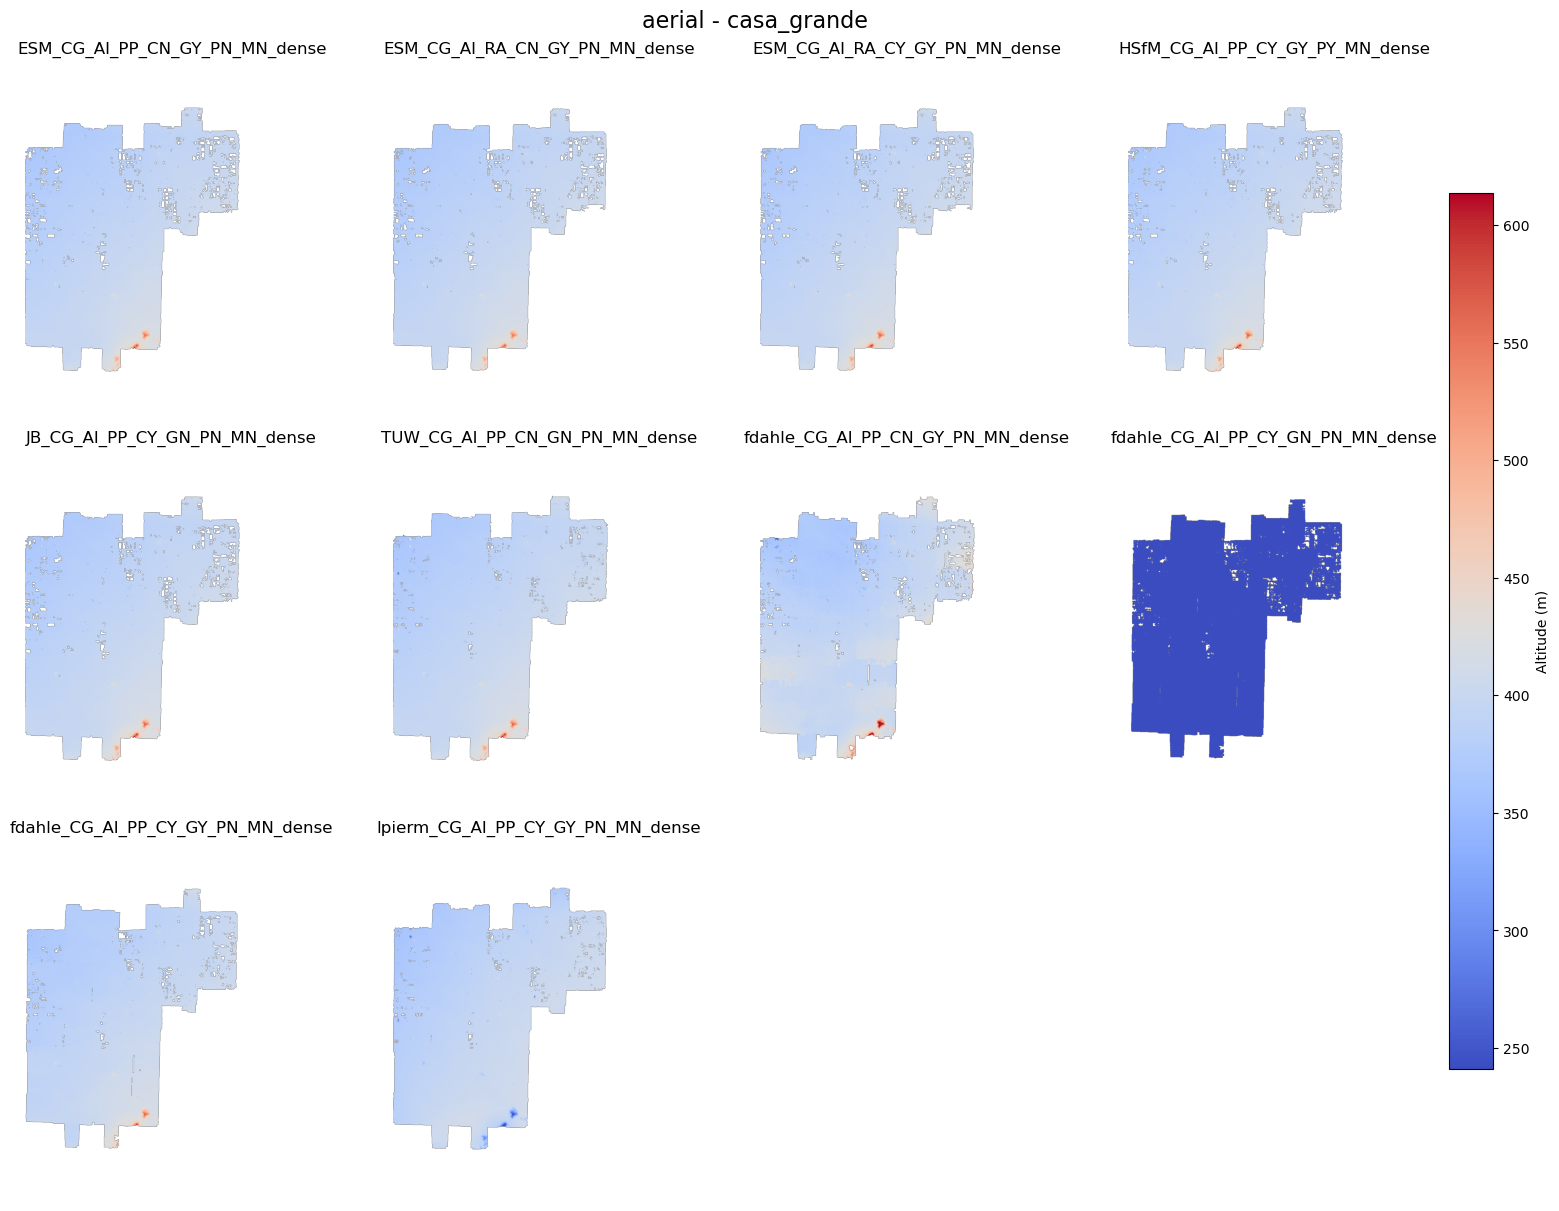

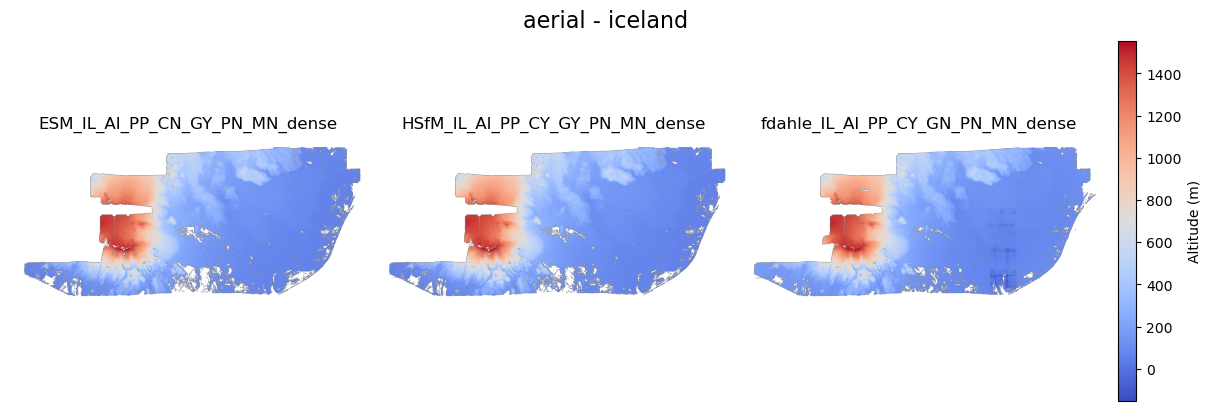

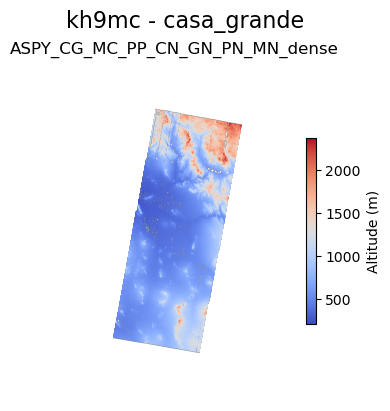

In [ ]:
output_directory = "/mnt/summer/USERS/DEHECQA/history/output/test_data/plots/raw_dems"
history.postprocessing.plotting2.plot_dems(postproc_df, output_directory=output_directory, plot=False)

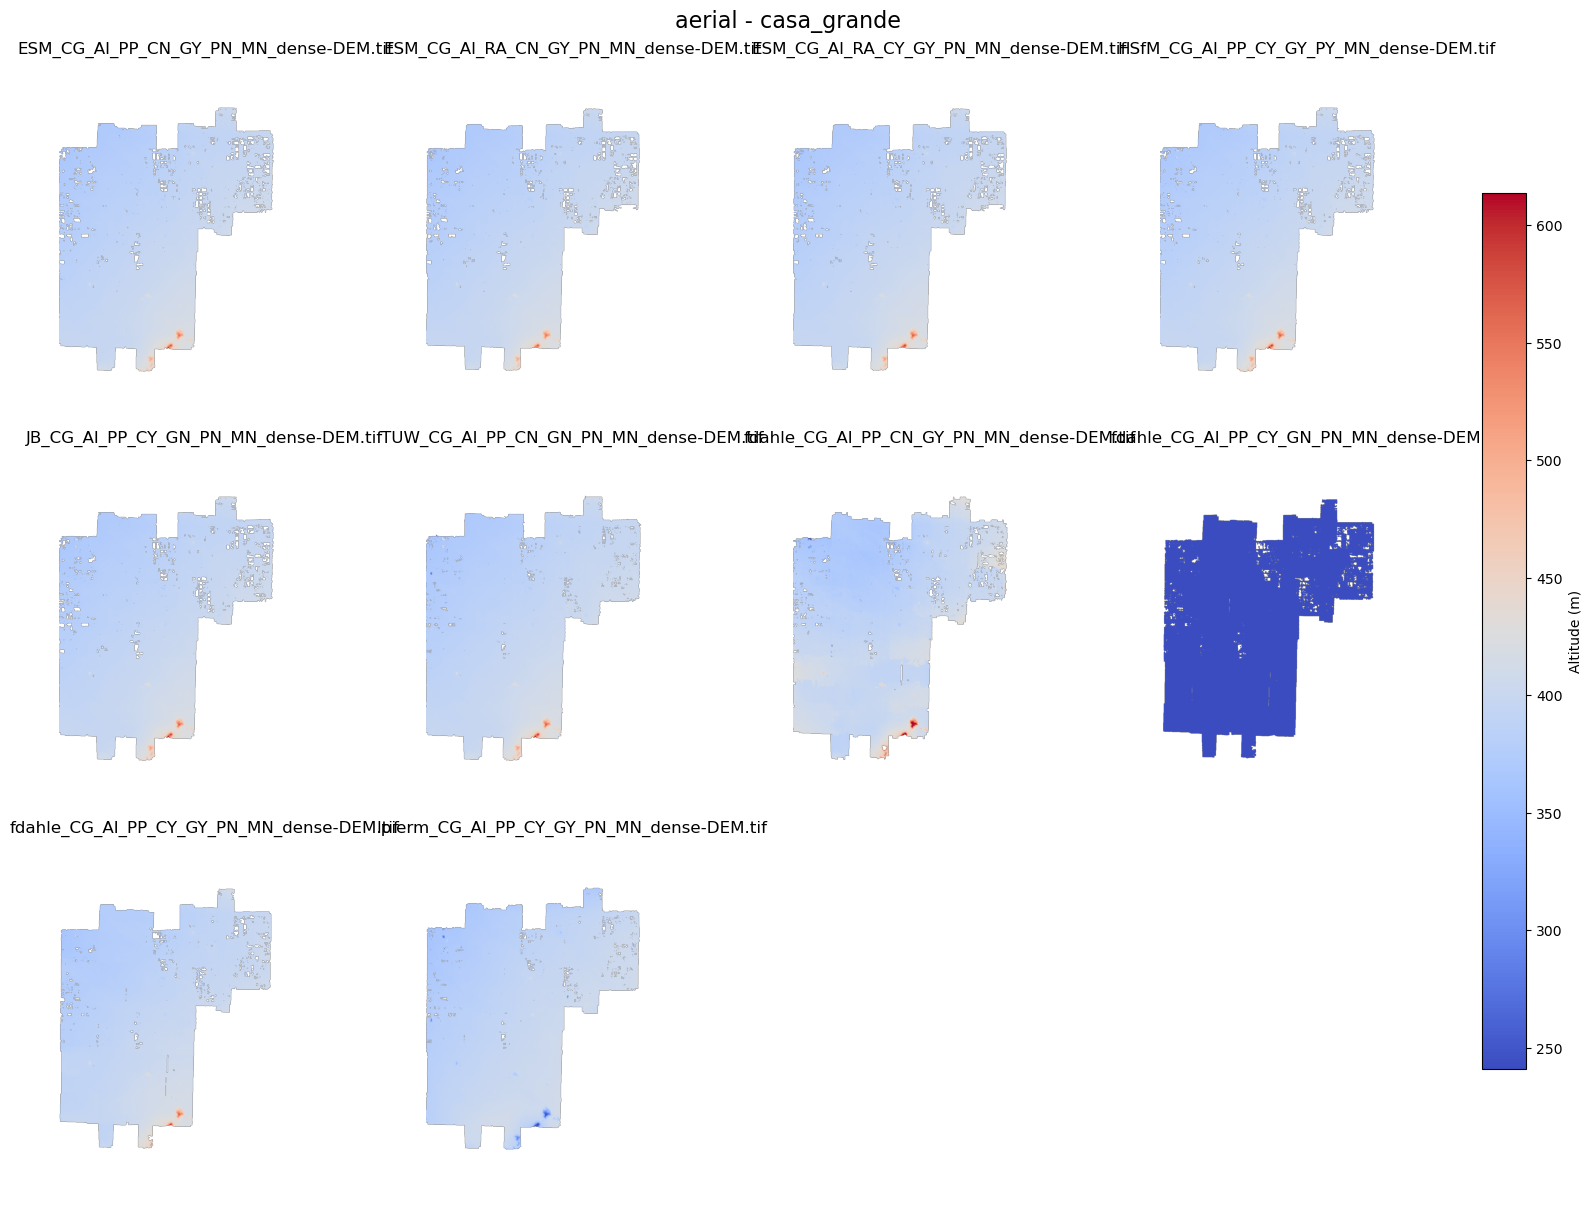

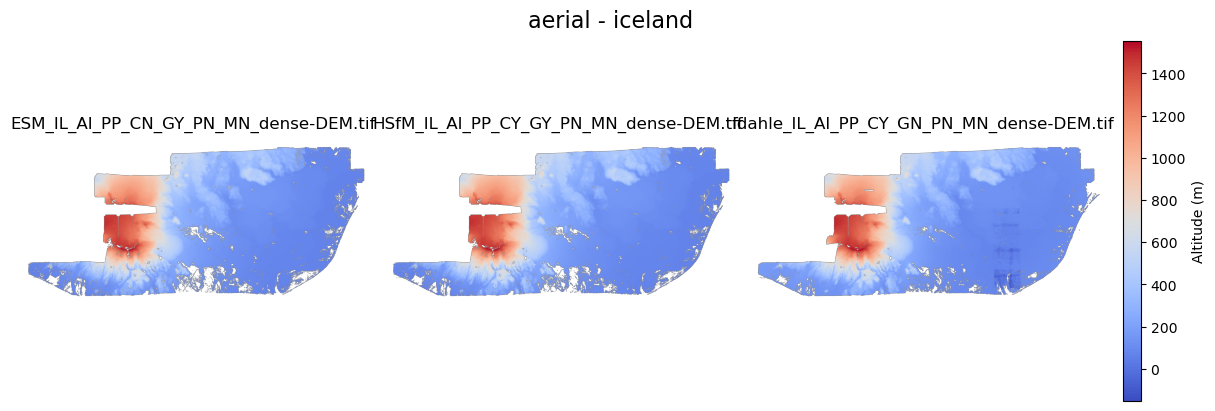

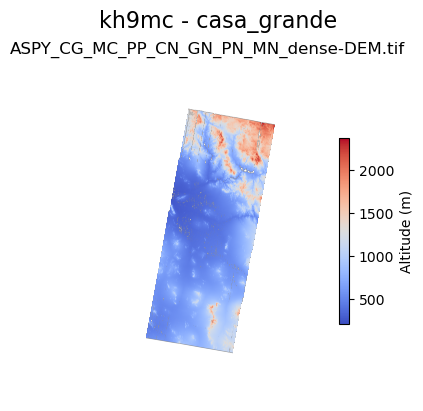

In [39]:
import matplotlib.pyplot as plt
import geoutils as gu
import numpy as np
from matplotlib.cm import ScalarMappable


res = postproc_df.dropna(subset=["raw_dem_file"]).groupby(["dataset", "site"])["raw_dem_file"].apply(list).to_dict()
max_cols = 4

for (dataset, site), dem_files in res.items():
    n = len(dem_files)
    ncols = min(max_cols, n)
    nrows = (n + max_cols - 1) // max_cols

    # ⚡ Calcul du vmin et vmax sur tout le groupe
    min_list, max_list = [], []
    for dem_file in dem_files:
        dem = gu.Raster(dem_file)
        arr = dem.data
        min_list.append(np.nanmin(arr))
        max_list.append(np.nanmax(arr))
    vmin, vmax = np.median(min_list), np.median(max_list)


    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, dem_file in enumerate(dem_files):
        dem = gu.Raster(dem_file)
        axes[i].imshow(dem.data, cmap="coolwarm", vmin=vmin, vmax=vmax)
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(dem_file))

    # Masquer les cases vides si besoin
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    cbar = fig.colorbar(
        ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax)),
        ax=axes,
        orientation="vertical",
        fraction=0.03,
        pad=0.02
    )
    cbar.set_label("Altitude (m)")  # tu peux adapter le label
    
    plt.suptitle(f"{dataset} - {site}", fontsize=16)

    plt.show()

## Coregister DEMs

Coregister multiple DEMs in a directory to appropriate reference DEMs and return summary statistics.

This function iterates over all DEM files in `input_directory` ending with '-DEM.tif', 
selects the appropriate reference DEM and mask based on the site and dataset information,
and applies coregistration using the `coregister_dem` function. 

Coregistered DEMs are saved to `output_directory`. If `overwrite` is False, existing output files are skipped.
If `dry_run` is True, no coregistration is performed, only file names and planned operations are printed.

In [19]:
postproc_df = history.postprocessing.iter_coregister_dems(
    postproc_df, 
    COREGISTERED_DEM_DIRECTORY, 
    overwrite=OVERWRITE, 
    dry_run=DRY_RUN, 
    output_ddem_after_directory=DDEMS_DIRECTORY, 
    output_ddem_before_directory=DDEMS_DIRECTORY,
    output_plot_directory=DDEM_PLOTS_DIRECTORY
)

Skip MicMac_CG_AI_PP_CY_GY_PN_MN_dense : no DEM found
Skip lpierm_CG_AI_PP_CY_GY_PN_MN_dense : no DEM found
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ESM_IL_AI_PP_CN_GY_PN_MN_dense-DEM.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_30m.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_mask_30m.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/ESM_IL_AI_PP_CN_GY_PN_MN_dense-DEM_coreg.tif)
Skip ESM_IL_AI_RA_CN_GY_PN_MN_dense : no DEM found
Skip ESM_IL_AI_RA_CY_GY_PN_MN_dense : no DEM found
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/ESM_CG_AI_PP_CN_GY_PN_MN_dense-DEM.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/casa_grande_reference_dem_zoom_30m.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/casa_grande_reference_dem_zoom_mask_30m.tif, /mnt/summer/USERS/DEHEC

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/xdem/coreg/base.py:1027: OptimizeWarning: Covariance of the parameters could not be estimated
  results = params_fit_or_bin["fit_optimizer"](


Skip bob_CG_AI_PP_CY_GY_PN_MN_dense : no DEM found


In [21]:
postproc_df.to_csv("/mnt/summer/USERS/DEHECQA/history/output/test_data/postprocess1.csv")

In [ ]:


raster_mask = history.postprocessing.statistics.cumulative_mask_filled(COREGISTERED_DEM_DIRECTORY)



In [44]:
history.postprocessing.statistics.get_voids_from_rasters(COREGISTERED_DEM_DIRECTORY, raster_mask)

,filename,void_percentage
0,ESM_CG_AI_RA_CN_GY_PN_MN_dense-DEM.tif,39.247725
1,fdahle_CG_AI_PP_CN_GY_PN_MN_dense-DEM.tif,42.546884
2,HSfM_CG_AI_PP_CY_GY_PY_MN_dense-DEM.tif,37.400338
3,ESM_CG_AI_PP_CN_GY_PN_MN_dense-DEM.tif,37.872471
4,TUW_CG_AI_PP_CN_GN_PN_MN_dense-DEM.tif,36.035444
5,fdahle_CG_AI_PP_CY_GY_PN_MN_dense-DEM.tif,40.476899
6,ESM_CG_AI_RA_CY_GY_PN_MN_dense-DEM.tif,39.312107
7,fdahle_CG_AI_PP_CY_GN_PN_MN_dense-DEM.tif,42.509439


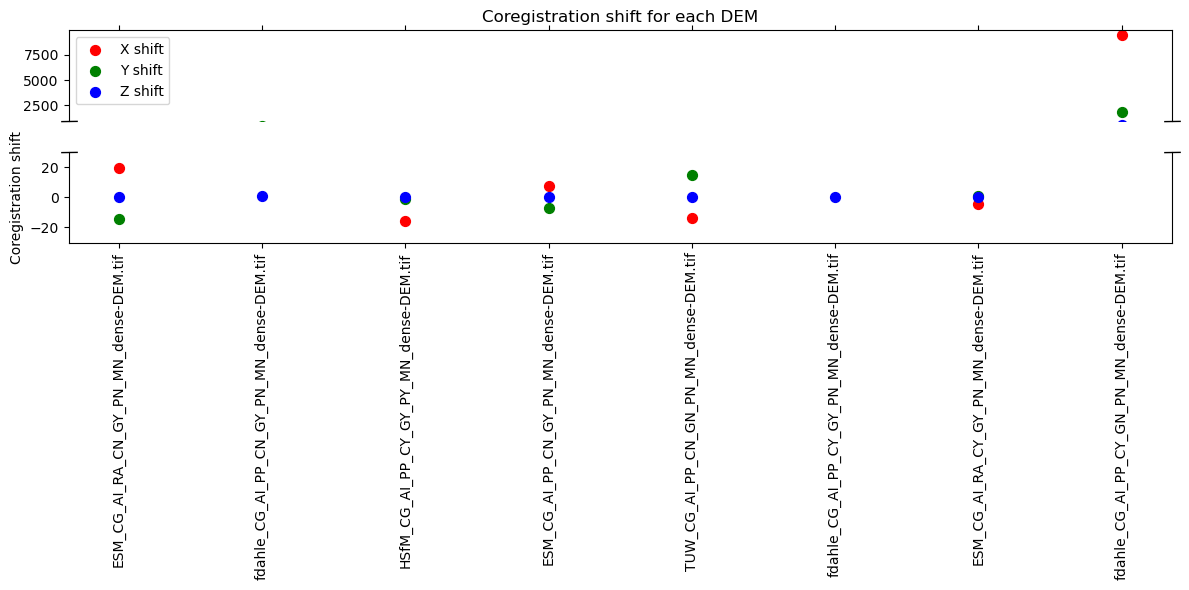

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)
x = range(len(df))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))
fig.subplots_adjust(hspace=0.05)

# Tracer chaque shift avec couleurs
colors = ["red", "green", "blue"]
labels = ["X shift", "Y shift", "Z shift"]
for col, color, label in zip(["coreg_shift_x","coreg_shift_y","coreg_shift_z"], colors, labels):
    ax1.scatter(x, df[col], color=color, s=50, label=label)
    ax2.scatter(x, df[col], color=color, s=50, label=label)

# Limites Y
ax1.set_ylim(1000, df[["coreg_shift_x","coreg_shift_y","coreg_shift_z"]].max().max()*1.05)  # outliers
ax2.set_ylim(-30, 30)  # majorité des valeurs

# Couper les spines
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Slanted lines pour indiquer la coupure
d = .015
kwargs = dict(marker=[(-1,-d),(1,d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Labels DEM
ax2.set_xticks(x)
ax2.set_xticklabels(df.index, rotation=90)

ax2.set_ylabel("Coregistration shift")
ax1.legend(loc="upper left")
ax1.set_title("Coregistration shift for each DEM")
plt.tight_layout()
plt.show()


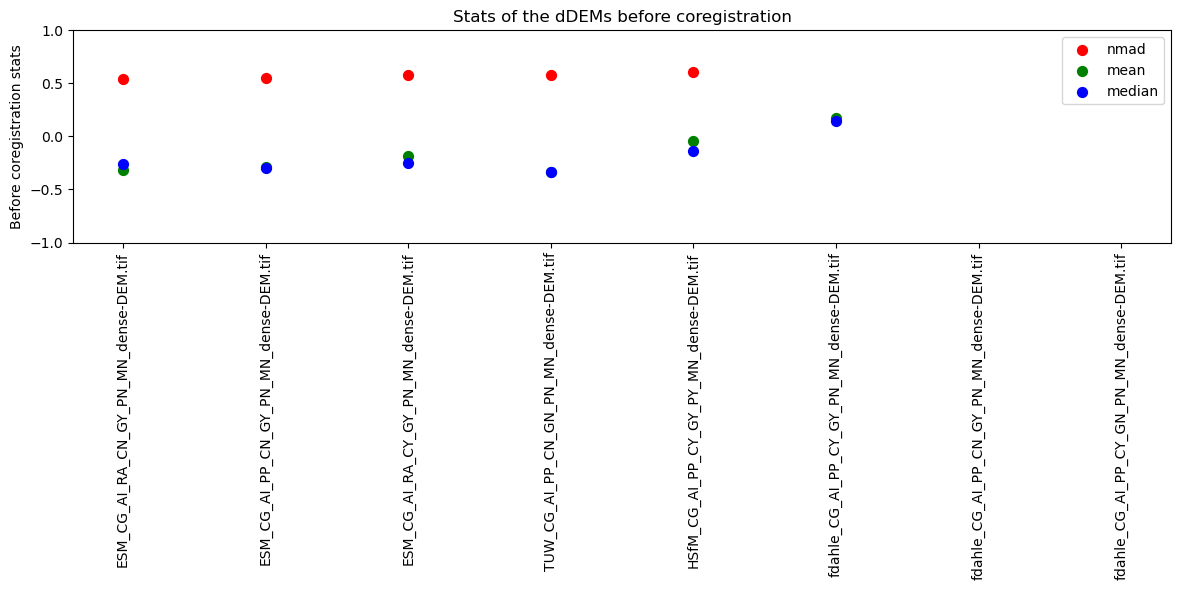

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Charger CSV
df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)

# Trier par nmad
df = df.sort_values("before_coreg_nmad")

# Positions X
x = range(len(df))

# Plot
fig, ax = plt.subplots(figsize=(12,6))

colors = ["red", "green", "blue"]
labels = ["nmad", "mean", "median"]

for col, color, label in zip(["before_coreg_nmad","before_coreg_mean","before_coreg_median"], colors, labels):
    ax.scatter(x, df[col], color=color, s=50, label=label)

ax.set_title("Stats of the dDEMs before coregistration")
ax.set_ylim(-1, 1)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=90)

ax.set_ylabel("Before coregistration stats")
ax.legend()
plt.tight_layout()
plt.show()


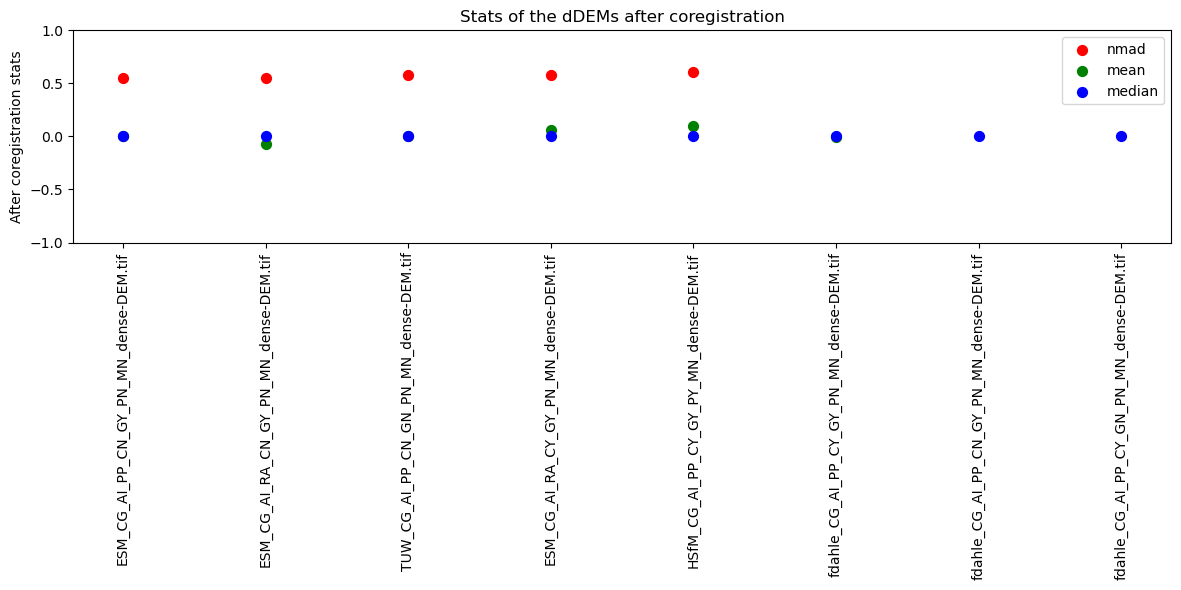

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Charger CSV
df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)

# Trier par nmad
df = df.sort_values("after_coreg_nmad")

# Positions X
x = range(len(df))

# Plot
fig, ax = plt.subplots(figsize=(12,6))

colors = ["red", "green", "blue"]
labels = ["nmad", "mean", "median"]

for col, color, label in zip(["after_coreg_nmad","after_coreg_mean","after_coreg_median"], colors, labels):
    ax.scatter(x, df[col], color=color, s=50, label=label)

ax.set_title("Stats of the dDEMs after coregistration")
ax.set_ylim(-1, 1)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=90)

ax.set_ylabel("After coregistration stats")
ax.legend()
plt.tight_layout()
plt.show()


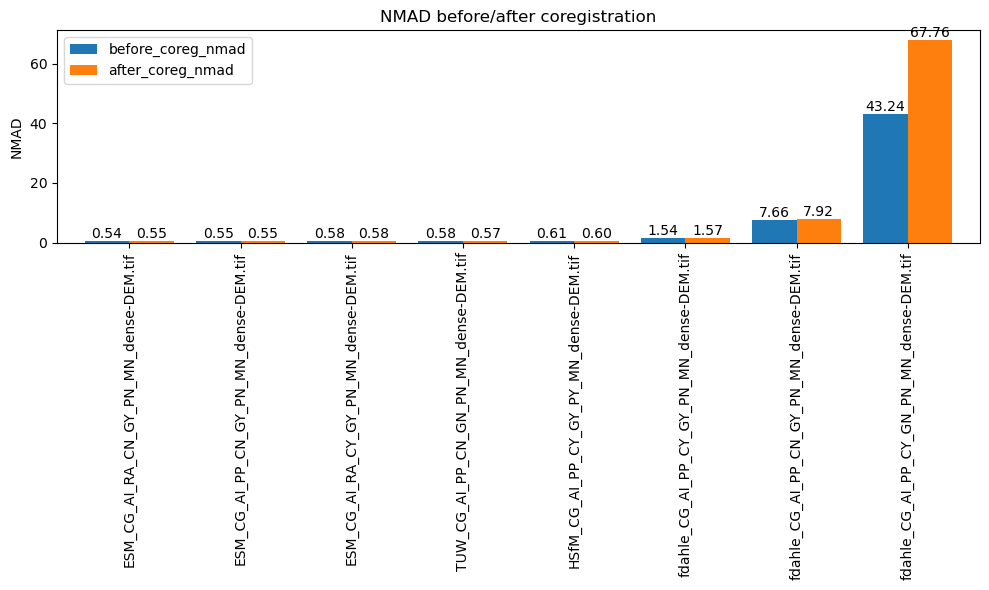

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Charger CSV
df = pd.read_csv(os.path.join(DDEM_PLOTS_DIRECTORY, "statistics.csv"), index_col=0)

# Colonnes à comparer
cols = ["before_coreg_nmad", "after_coreg_nmad"]

# Trier selon before_coreg_nmad
df_sorted = df.sort_values("before_coreg_nmad", ascending=True)

# Création du barplot
ax = df_sorted[cols].plot(kind="bar", figsize=(10,6), width=0.8)

# Ajouter labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

# Mise en forme
ax.set_ylabel("NMAD")
ax.set_title("NMAD before/after coregistration")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


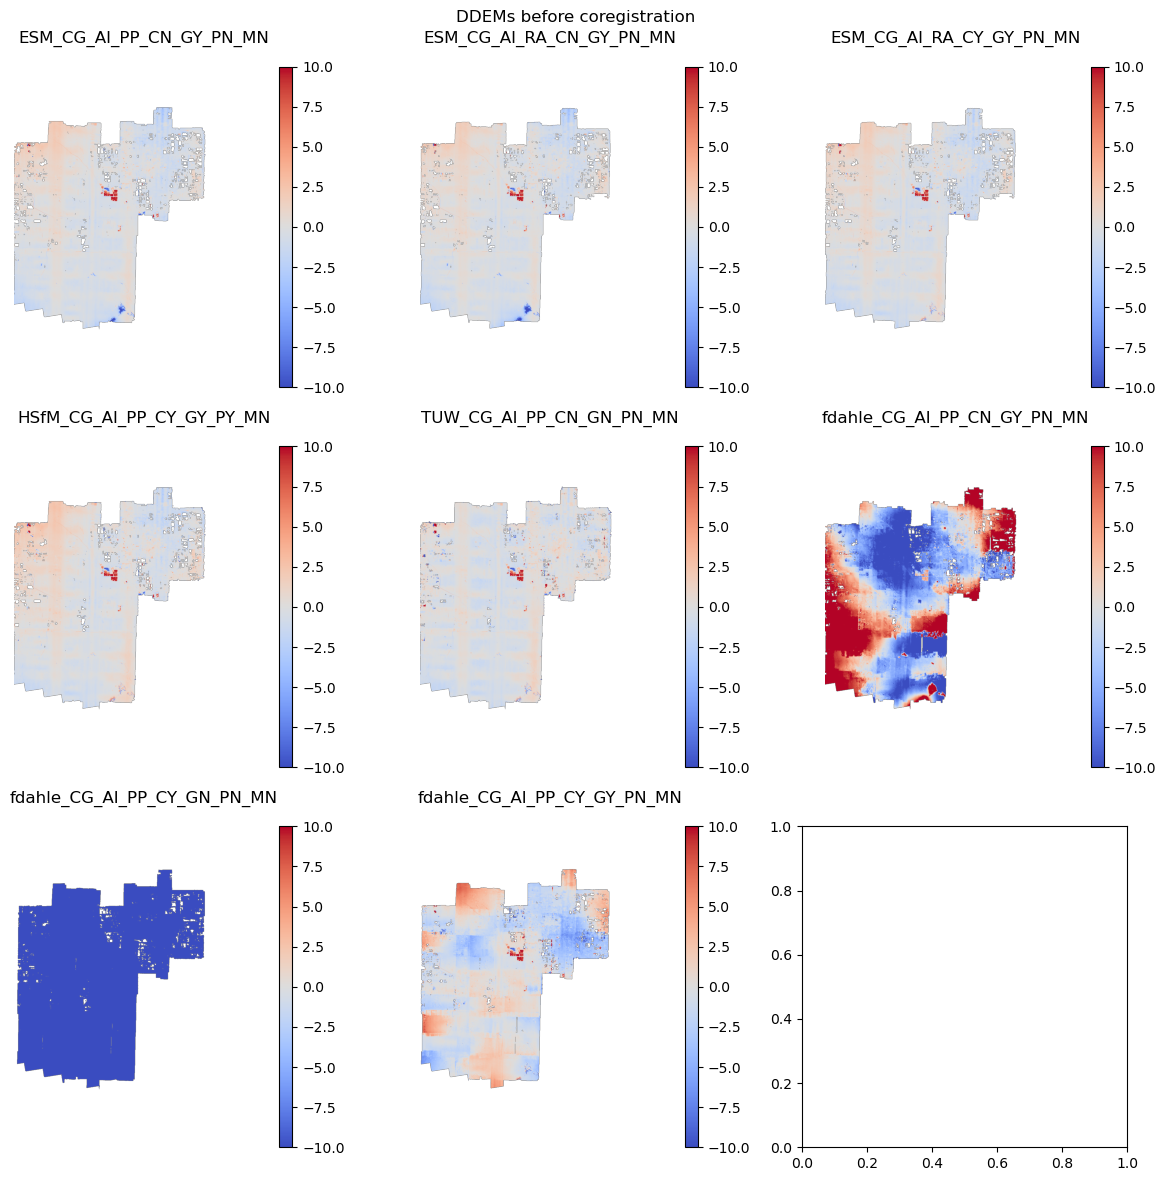

In [125]:
import geoutils as gu

raster_files = sorted(glob(os.path.join(DDEMS_DIRECTORY, "*_before.tif")))

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("DDEMs before coregistration")
axes = axes.flatten()

for i, raster_file in enumerate(raster_files):
    raster = gu.Raster(raster_file)
    raster.plot(ax=axes[i], vmin=-10, vmax=10, cmap="coolwarm")
    axes[i].set_title(os.path.basename(raster_file).split("_dense")[0])
    axes[i].axis("off")
plt.tight_layout()
plt.show()


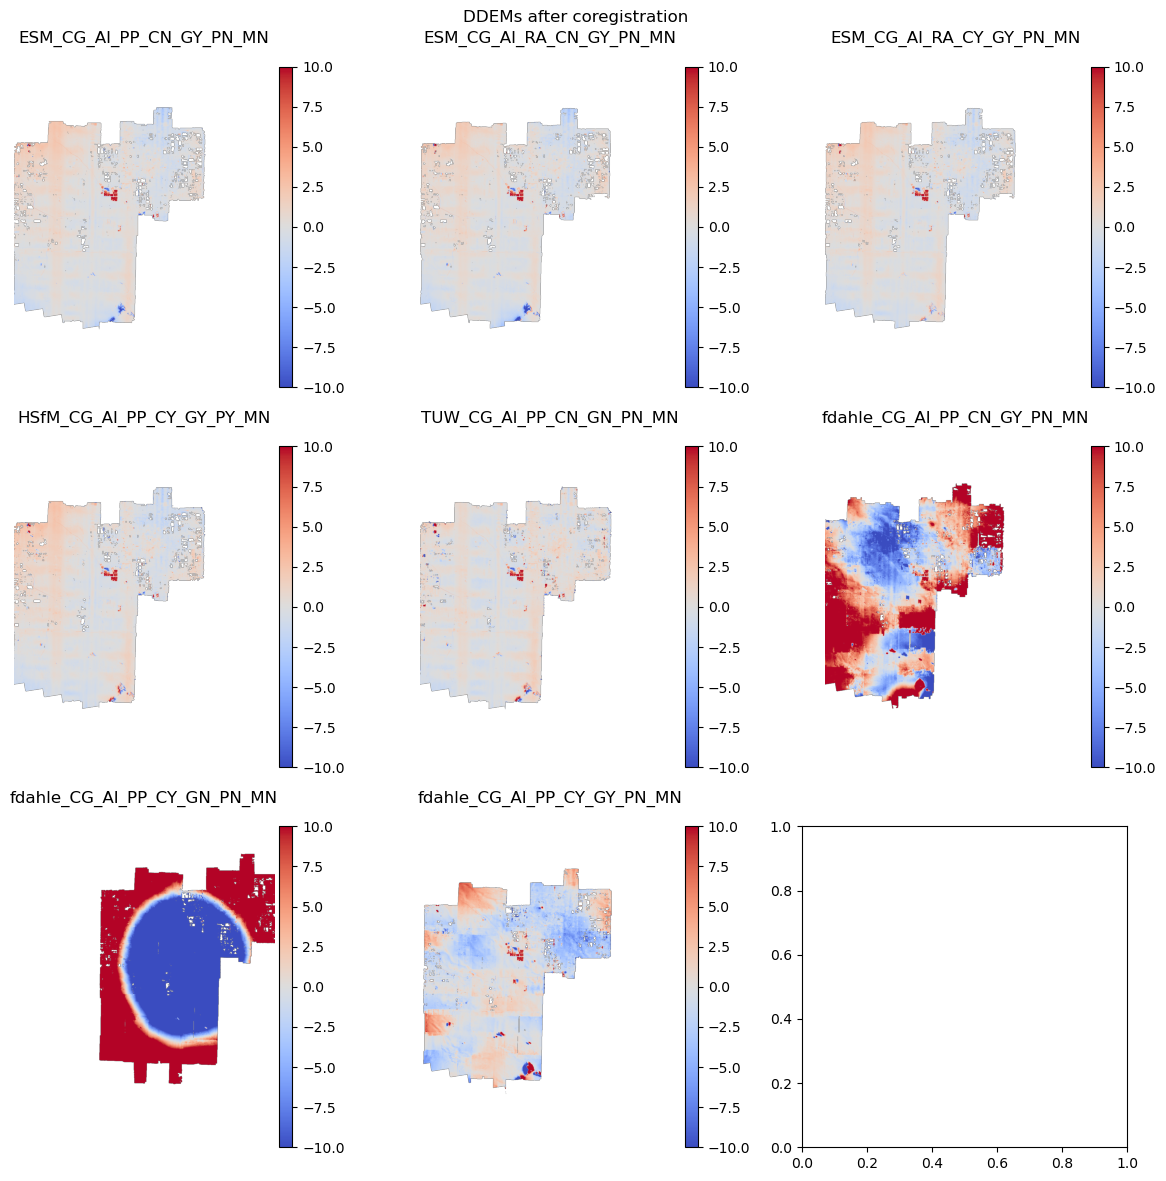

In [126]:
import geoutils as gu

raster_files = sorted(glob(os.path.join(DDEMS_DIRECTORY, "*_after.tif")))

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("DDEMs after coregistration")
axes = axes.flatten()

for i, raster_file in enumerate(raster_files):
    raster = gu.Raster(raster_file)
    raster.plot(ax=axes[i], vmin=-10, vmax=10, cmap="coolwarm")
    axes[i].set_title(os.path.basename(raster_file).split("_dense")[0])
    axes[i].axis("off")
plt.tight_layout()
plt.show()


In [ ]:
history.postprocessing.create_std_ddem(DDEMS_DIRECTORY, os.path.join(DDEMS_DIRECTORY, "ddem_std.tif"))

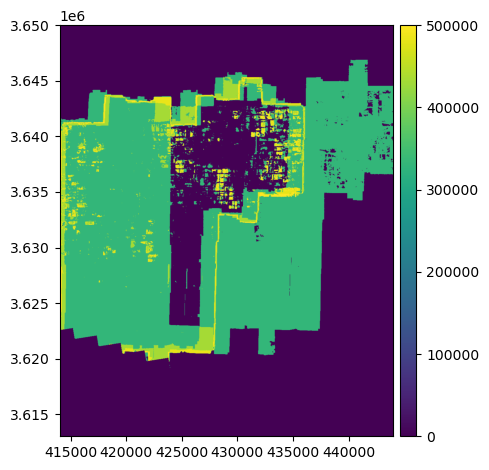

In [31]:
import geoutils as gu

dem_ref = gu.Raster(os.path.join(DDEMS_DIRECTORY, "ddem_std.tif"))
dem_ref.plot()

In [59]:
import geoutils as gu
import numpy as np
import pandas as pd

dem_file = "/home/godinlu/github/history/dev/testset/coregistered_dems/HSfM_CG_AI_PP_CY_GY_PY_MN_dense-DEM.tif"
landcover_file = "/home/godinlu/github/history/dev/testset/ref_dems/casa_grande_landcover_zoom_30m.tif"

# Charger les rasters
dem = gu.Raster(dem_file)
landcover = gu.Raster(landcover_file)

assert dem.shape == landcover.shape
assert dem.transform == landcover.transform

# Masque des nodata dans le DEM
dem_is_nodata = dem.data.mask

# Tableau numpy du landcover
lc_array = landcover.data.astype(int)

# Classes uniques du landcover
classes = np.unique(lc_array[~np.isnan(lc_array)])

# Calcul des proportions
records = []
for cls in classes:
    cls_mask = lc_array == cls

    total = np.count_nonzero(cls_mask)
    nodata = np.count_nonzero(cls_mask & dem_is_nodata)

    proportion = nodata / total if total > 0 else np.nan

    records.append({
        "landcover_class": cls,
        "total_pixels": total,
        "nodata_pixels": nodata,
        "proportion_nodata": proportion
    })

# Convertir en DataFrame pour analyse
df = pd.DataFrame(records)

print(df)


    landcover_class  total_pixels  nodata_pixels  proportion_nodata
0                10          3994           2133           0.534051
1                11           266            148           0.556391
2                12           273            153           0.560440
3                13           243            130           0.534979
4                14           209            100           0.478469
..              ...           ...            ...                ...
66               76            17              8           0.470588
67               77             9              5           0.555556
68               78            17             13           0.764706
69               79            18              6           0.333333
70               80           933            575           0.616292

[71 rows x 4 columns]


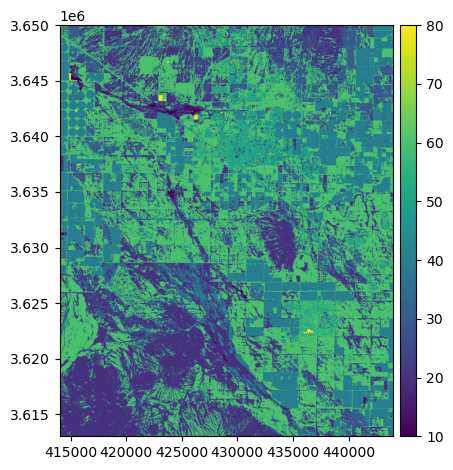

In [57]:
landcover = gu.Raster(landcover_output_file)
landcover.plot()